# Empalme con la clase anterior

# Ejemplo de LSTM para la predicción de la próxima palabra.
No estoy seguro que el ejemplo corra completamente en GoogleColab. Vamos a tratar.

El ejercicio es intersante por que va implicar:
* Bajar datos de Kaggle (la net)
* leer los datos (texto: SherlockHolmes.txt)
* Procesar texto.
* Crear los datos en grupos consecutivos de 3 palabras para predecir, la que sigue.
* Crear un modelo LSTM en `python` .
* Probar el modelo.

Este ejemplo se basa en
[este video](https://www.youtube.com/watch?v=Zn22qt7j2dM)

Pasos:

* Bajar los datos de Kaggle:
[Visit Kaggle](https://www.kaggle.com/datasets/adangonzalez/sherlock-holmes-txt) y baje los datos de allí.



In [10]:
# import libraries
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!cd /root
!mkdir -p ~/.kaggle


Voy al sitio de Kaggle, log in, voy al avatar en la derecha superior y luego a settings, y hagoe click en New API token. Esto me baja el archivo kaggle.json con las credenciales de API.



In [13]:
import shutil
shutil.copyfile('/content/kaggle.json', '/root/.kaggle/kaggle.json')

'/root/.kaggle/kaggle.json'

In [14]:
!chmod 600 /root/.kaggle/kaggle.json

In [15]:
# leer el archivo
!kaggle datasets download -d adangonzalez/sherlock-holmes-txt

Dataset URL: https://www.kaggle.com/datasets/adangonzalez/sherlock-holmes-txt
License(s): unknown
  0% 0.00/221k [00:00<?, ?B/s]
100% 221k/221k [00:00<00:00, 612MB/s]


In [16]:
# descomprimir el zip
!unzip sherlock-holmes-txt.zip

Archive:  sherlock-holmes-txt.zip
  inflating: Sherlock.txt            


In [17]:
# abrir el archivo
file = open('/content/Sherlock.txt', 'r', encoding='utf-8')

In [18]:
file

<_io.TextIOWrapper name='/content/Sherlock.txt' mode='r' encoding='utf-8'>

In [19]:
# creamos lineas
lines = []
for i in file:
    lines.append(i)

lines[:20] #QC

['The Adventures of Sherlock Holmes\n',
 '\n',
 'by Arthur Conan Doyle\n',
 '\n',
 '\n',
 'Contents\n',
 '\n',
 '   I.     A Scandal in Bohemia\n',
 '   II.    The Red-Headed League\n',
 '   III.   A Case of Identity\n',
 '   IV.    The Boscombe Valley Mystery\n',
 '   V.     The Five Orange Pips\n',
 '   VI.    The Man with the Twisted Lip\n',
 '   VII.   The Adventure of the Blue Carbuncle\n',
 '   VIII.  The Adventure of the Speckled Band\n',
 '   IX.    The Adventure of the Engineer’s Thumb\n',
 '   X.     The Adventure of the Noble Bachelor\n',
 '   XI.    The Adventure of the Beryl Coronet\n',
 '   XII.   The Adventure of the Copper Beeches\n',
 '\n']

In [20]:
# juntamos las lineas
data = ""
for i in lines:
    data = ' '.join(lines)

data[:100]


'The Adventures of Sherlock Holmes\n \n by Arthur Conan Doyle\n \n \n Contents\n \n    I.     A Scandal in B'

In [21]:
# data processing
# remove backslashes and other things
data1 = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
data1[:1000]

'The Adventures of Sherlock Holmes  by Arthur Conan Doyle   Contents     I.     A Scandal in Bohemia    II.    The Red-Headed League    III.   A Case of Identity    IV.    The Boscombe Valley Mystery    V.     The Five Orange Pips    VI.    The Man with the Twisted Lip    VII.   The Adventure of the Blue Carbuncle    VIII.  The Adventure of the Speckled Band    IX.    The Adventure of the Engineer’s Thumb    X.     The Adventure of the Noble Bachelor    XI.    The Adventure of the Beryl Coronet    XII.   The Adventure of the Copper Beeches     I. A SCANDAL IN BOHEMIA   I.  To Sherlock Holmes she is always _the_ woman. I have seldom heard him mention her under any other name. In his eyes she eclipses and predominates the whole of her sex. It was not that he felt any emotion akin to love for Irene Adler. All emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. He was, I take it, the most perfect reasoning and observing machine that the wor

In [22]:
# remover muliples espacios, separar palabras en lineas
data2 = data1.split()
data2[:10]

['The',
 'Adventures',
 'of',
 'Sherlock',
 'Holmes',
 'by',
 'Arthur',
 'Conan',
 'Doyle',
 'Contents']

In [23]:
# se vuelven a juntar las palabras pero ya sin espacios adicionales.
data = ' '.join(data2)
data[:1000]

'The Adventures of Sherlock Holmes by Arthur Conan Doyle Contents I. A Scandal in Bohemia II. The Red-Headed League III. A Case of Identity IV. The Boscombe Valley Mystery V. The Five Orange Pips VI. The Man with the Twisted Lip VII. The Adventure of the Blue Carbuncle VIII. The Adventure of the Speckled Band IX. The Adventure of the Engineer’s Thumb X. The Adventure of the Noble Bachelor XI. The Adventure of the Beryl Coronet XII. The Adventure of the Copper Beeches I. A SCANDAL IN BOHEMIA I. To Sherlock Holmes she is always _the_ woman. I have seldom heard him mention her under any other name. In his eyes she eclipses and predominates the whole of her sex. It was not that he felt any emotion akin to love for Irene Adler. All emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. He was, I take it, the most perfect reasoning and observing machine that the world has seen, but as a lover he would have placed himself in a false position. He 

# Tokenization:
Las palabras se convierten a numeros. Queda una lista grande de numeros correspondientes a las palabras. La Tokenizacion es como la vectorizacion del lenguaje.

In [24]:
import itertools
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
word_index = tokenizer.word_index

# QC muestre la primeras 10 palabras con sus tokens
dict(itertools.islice(word_index.items(), 10))


{'the': 1,
 'and': 2,
 'to': 3,
 'of': 4,
 'i': 5,
 'a': 6,
 '”': 7,
 'in': 8,
 'that': 9,
 'it': 10}

In [25]:
sequential_data =  tokenizer.texts_to_sequences([data])[0]
sequential_data[:10]

[1, 1406, 4, 132, 34, 48, 698, 4604, 4605, 1844]

In [26]:
# la dimension del vector
len(sequential_data)

107995

In [27]:
# tamaño del vocabulario
vocab_size = len(word_index)
vocab_size

8642

In [28]:
# creae sequences of three words.
sequences = []
for i in range(3, len(sequential_data)):
    words = sequential_data[i-3:i+1]
    sequences.append(words)

len(sequences)

107992

In [29]:
# converir sequences a arreglos
sequences = np.array(sequences)
sequences[:10]

array([[   1, 1406,    4,  132],
       [1406,    4,  132,   34],
       [   4,  132,   34,   48],
       [ 132,   34,   48,  698],
       [  34,   48,  698, 4604],
       [  48,  698, 4604, 4605],
       [ 698, 4604, 4605, 1844],
       [4604, 4605, 1844,    5],
       [4605, 1844,    5,    6],
       [1844,    5,    6,  850]])

In [30]:
# define input output pairs.
X = []
y =[]
for i in sequences:
    X.append(i[0:3])
    y.append(i[3])

X = np.array(X)
y = np.array(y)

In [ ]:
X[:10]

array([[   1, 1406,    4],
       [1406,    4,  132],
       [   4,  132,   34],
       [ 132,   34,   48],
       [  34,   48,  698],
       [  48,  698, 4604],
       [ 698, 4604, 4605],
       [4604, 4605, 1844],
       [4605, 1844,    5],
       [1844,    5,    6]])

In [ ]:
y[:10]

array([ 132,   34,   48,  698, 4604, 4605, 1844,    5,    6,  850])

In [31]:
type(X)

numpy.ndarray

In [32]:
# convertir y a categorical (one-hot encoded)
y = to_categorical(y, num_classes=vocab_size + 1)
y[0] # QC

array([0., 0., 0., ..., 0., 0., 0.])

In [33]:
len(y[0])

8643

In [34]:
max(y[0])

np.float64(1.0)

In [35]:
np.argmax(y[0])

np.int64(132)

In [36]:
y[0][130:140]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [37]:
# build the lstm
nunits=1000
sequence_length = 3
model = Sequential()
model.add(Embedding(vocab_size+1, output_dim=10, input_shape=(sequence_length,)))
model.add(LSTM(nunits, return_sequences=True))
model.add(LSTM(nunits))

# add two dense layers
model.add(Dense(nunits, activation='relu'))
model.add(Dense(vocab_size+1, activation='softmax'))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 3, 10)          │        86,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 1000)        │     4,044,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1000)           │     8,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8643)           │     8,651,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,787,073 (83.11 MB)

 Trainable params: 21,787,073 (83.11 MB)

 Non-trainable params: 0 (0.00 B)

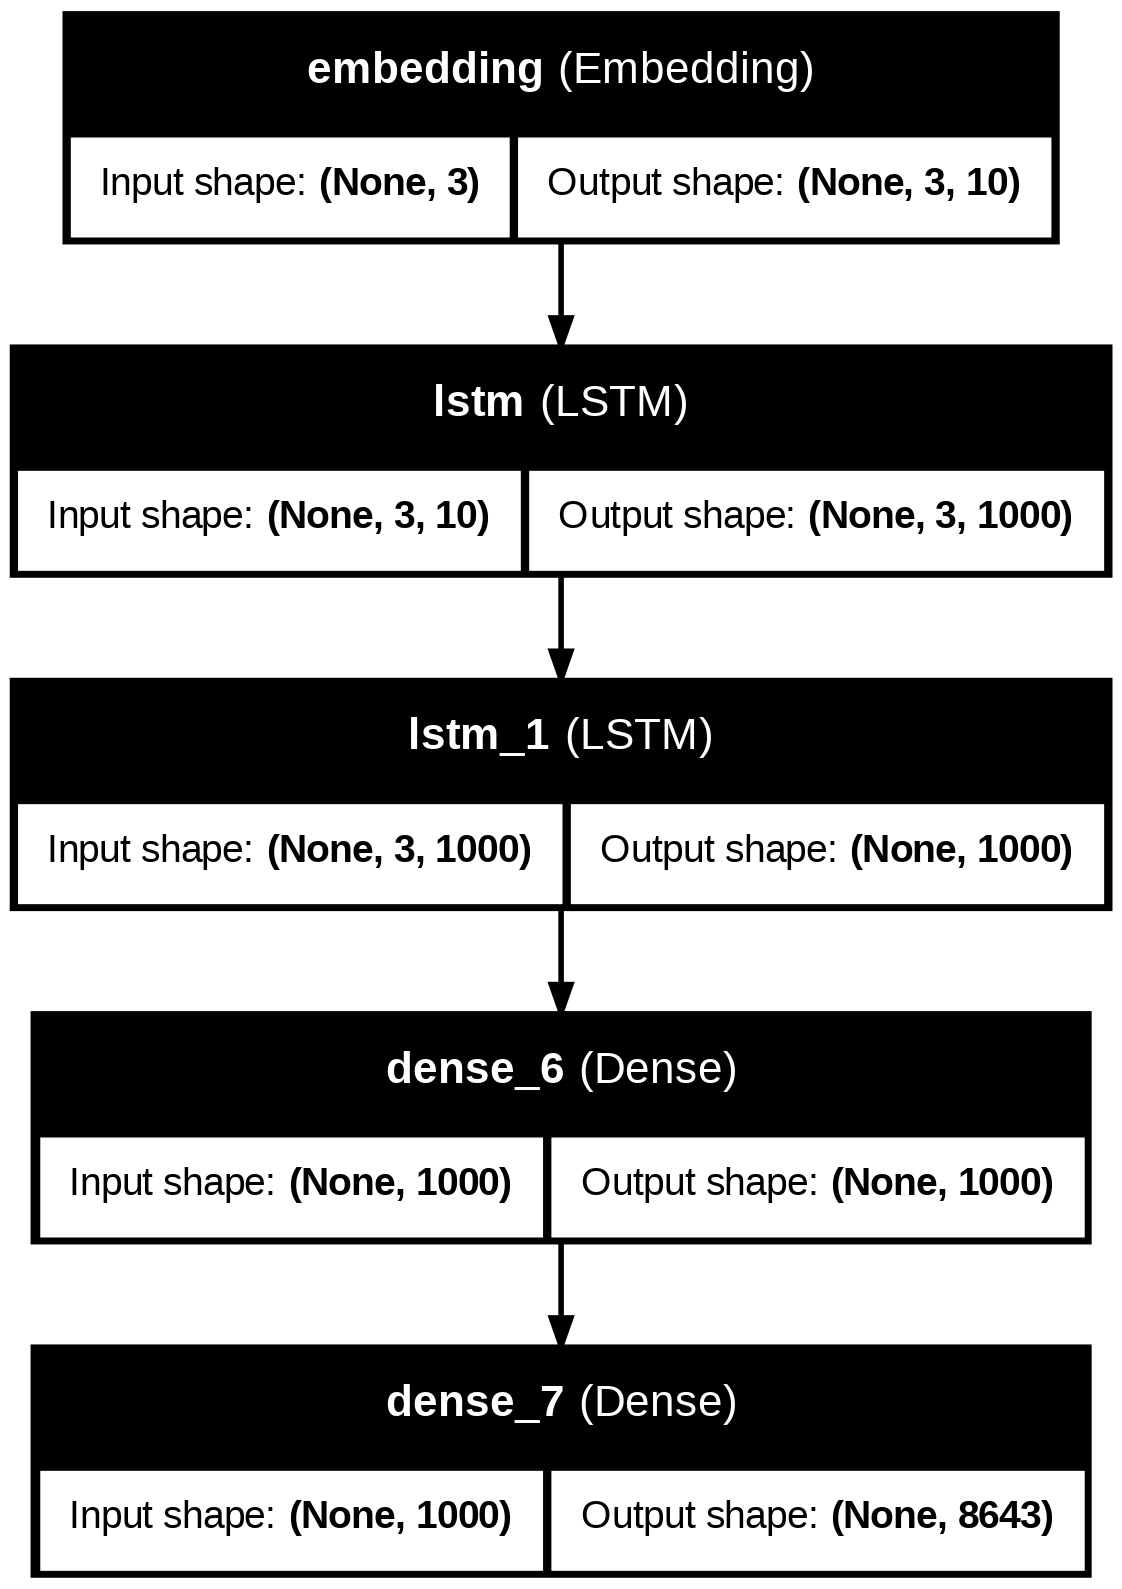

In [38]:
# plot the model
from tensorflow.keras.utils import plot_model

# plot the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)



In [ ]:
# compile and train the model
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, batch_size=128, epochs=2)

# Gated Recurrent Units (GRU).
Es otra alternativa para la LSTM pero tiene menos parámetros que la LSTM. En algunos casos tiene mejor performance pero en casos como la polifonía musical, modelamiento de voz, NLP, en general es compatible. Este método fue introducido por Cho et. al (ver referencia en  las notas de clase).

La Figura 5.38 iulstra la arquitectura del GRU.

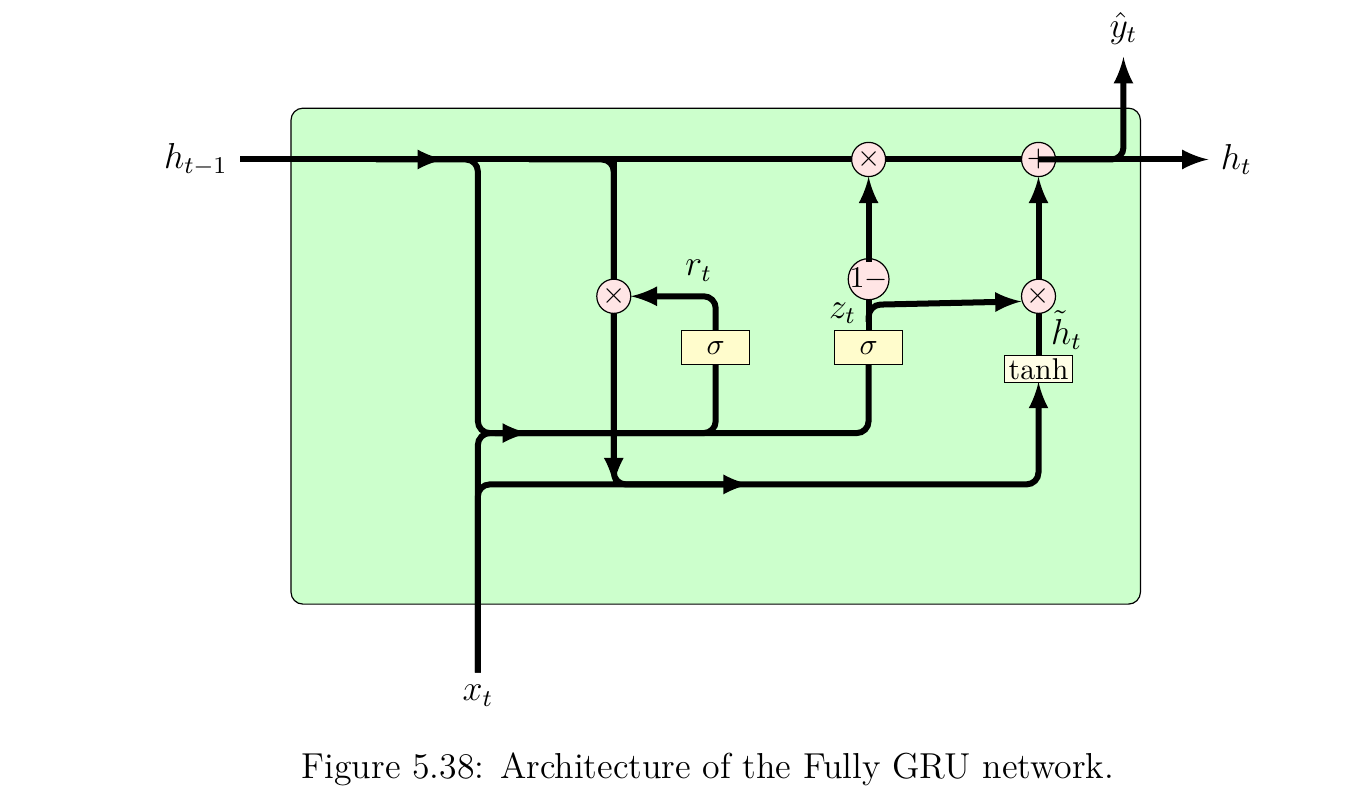

Como no tiene output gate no iene menos parametros. Noten que tampoco tiene cell $c_t$ (long term). Entonces dirian ustedes que no es bueno para el vanishing/exploding problems. Digamos que si lo es. En una RNN tradicional

$$h_t = f(W h_{t-1} + Ux + b_t) $$
Al  sacar el gradiente repetidas veces (tantas como tiempos $t$) la matriz $W$ se multiplica, una multiplicación continuada produce gradientes muy grandes si el radio espectral $\rho(W)>1$ o tendiendo a 0 si $\rho(W) < 1$.

Sin embargo en el GRU tenemos la siguiente arquitectura (matematica)

\begin{eqnarray}
z_t &=& \sigma( W_z x_t + U_z h_{t-1} + b_z) \\
r_t &=& \sigma(W_r x_t + U_r h_{t-1} + b_r) \\
\hat{h}_t &=& \tanh( W_h x_t + U_h r_t \circ h_{t-1} + b_h) \\
h_t &=& (1 - z_t) \circ h_{t-1} + z_t \circ h_t \tag{1}
\end{eqnarray}

La descripcion de los simbolos en esta ecuacion es:
* $z_t=$ **update gate** (compuerta de actualización). Decide que tanta información se pasa en el futuro.

* $r_t=$ **reset gate: Decide que tanto de la $h_{t-1}$ llevar.

* $x_t=$ **input vector**.

* $h_t=$: el estado oculto final

* $\hat{h}_t=$ **estado intermedio para calcular $h_t$.

Ver la Ecuacion (1)

$$ h_t = (1 - z_t) \circ h_{t-1} + z_t \circ h_t $$.
Cuando $z_t \approx 0$, entonces $\partial h_t /\partial h_{t-1} \approx I$, pues $h_t \approx h_{t-1}$.

La siguiente tabla muestra una comparación entre el LSTM y el GRU.

| **Model** | **Separate memory ($c_t$)?** | **Gates**                 | **Gradient mitigation**                              | **Performance summary**                            |
| :-------- | :--------------------------: | :------------------------ | :--------------------------------------------------- | :------------------------------------------------- |
| **LSTM**  |              Yes             | 3 (input, forget, output) | Excellent stability due to additive cell state       | Strong for long-term dependencies                  |
| **GRU**   |              No              | 2 (reset, update)         | Very good — update gate helps preserve gradient flow | Comparable; slightly weaker on very long sequences |


# Métodos semisupervisados, auto-supervisados, no supervisados.
## Introduccion:
* Los metodos semisupervisados usan algunas veces etiquetas, otras no. Un ejemplo es el GAN (Generative Adversary Networks), lo vemos más adelante. Otro mas claro es "recomender systems" . Algunos usuarios califican una película en Netflix, otros no. O un video en YouTube, otros no. Auto-supervisados (self-supervised), es una categoría reciente. El mejor emeplo para esto es el ejercicio que acabamos de hacer con la historia de Sherlock Holmes. Usamos el mismo texto para definir datos y etiquetas. Ejemplos hay muchos, particularmente los Large Language Models (LLMs).

Otro ejemplo de auto-supervisados son los **autoencoders** como veremos a continuación.

Hoja de ruta a largo plazo. Pensamos en metodos generativos. Que generan nuevos datos, imagenes, texto, audios, etc.

* auto-encoders (variational auto-encoders)
    * compresión de datos
    * remover ruido
    * generar musica, texto, u otros

* GANs. (dos redes en paralelo)

## Autoencoders.
Los autoencoders son dos redes pegadas (en serie).
Veamos la Figura 5.40




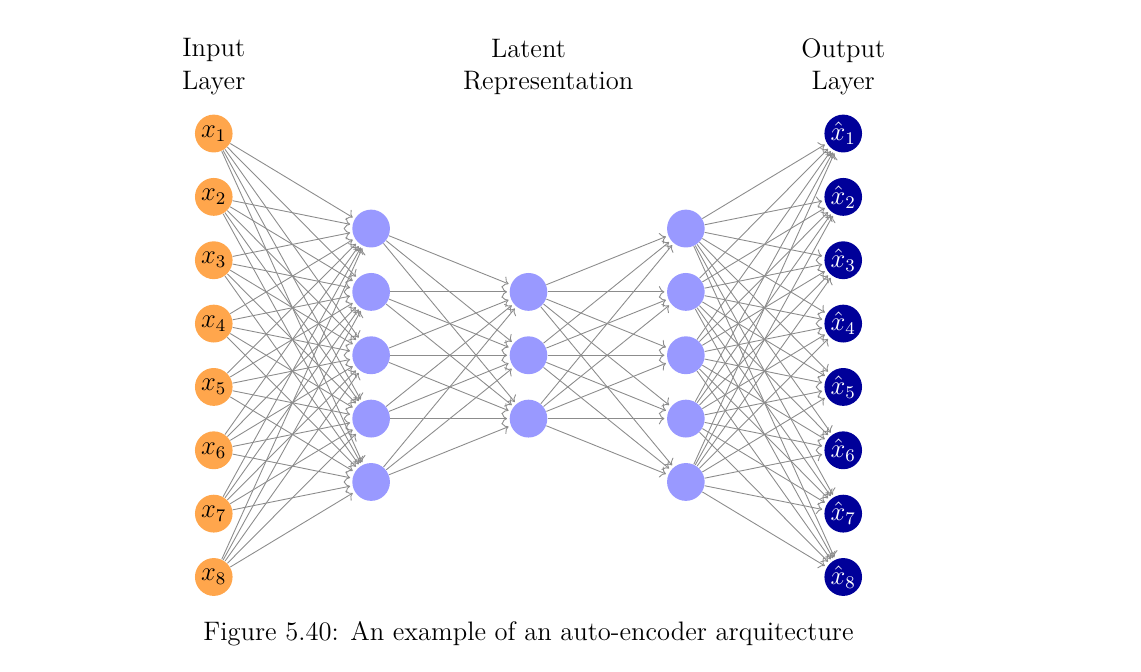

La arquitectura en la figura 5.40 muestra

* La primera parte (la izquierda) desde los datos de entrada hasta el medio que se llama **latent space** (tiene 3 nodos).
A esta red (sub-red) se llama **encoder** (codificador).

* La segunda parte (la derefha) desde el **latent space** hasta la salida, se le llama el **decoder** (decodificador).

Si el autoencoder es perfecto la salida es igual a la entrada (por eso digo auto-supervisado).

Esto motiva la siguiente función de costo

$$J(\theta) = \| x - \hat{x} \|²  + \lambda R(x). $$
Un ejemplo de regularización esta dado por Rifai (referencia está en las notas de clase).

$$R(x) = \left \| \frac{\partial f(x)}{\partial x} \right \| $$

Recuerde que la matriz $\partial f/\partial x$ es una matriz jacobiana por que tanto $f$ como $x$ son vectores.
$f$ debe ser el modelo (la propagación hacia adelante con las funciones de activación que eso conlleva).



Algunas aplicaciones de los autoencoders son:

* Reducción de dimensionalidad (la próxima sección)
* modelos generativos (crear musica, poesia, imágenes, etc)
* Eliminación de ruido (próxima clase)
* detección de anomalías (no lo estudiamos en este curso).


### Reducción de dimensionalidad con auto-encoders.
Volviendo a la Figura 5.40  es clara la reducción de 8 nodos a 3 nodos. De alguna forma la idea es expresar los datos en la mínima cantidad de dimensiones posible. A esta mínima cantidad se le llama **intrinsic dimension** (dimension intrínsica).

A la vez que mostramos ejemplos hacemos una comparación con PCA.

Una recta es una variedad (manifold) que dimension 1. La recta puede estar "embedded" en un espacio de, por ejemplo, 1 millón de dimensiones. Matemáticamente, la representación **paramétrica** de la recta es como sigue

Asuma $P, Q, L_{PQ} \in \mathbb{R}^{10^6}$
\begin{eqnarray}
L_{PQ} : \mathbb{R} &\to& \mathbb{R}^{10^6} \\
t &\mapsto& L_{PQ}(t) = P + t (Q - P).
\end{eqnarray}
Es un "engaño" pensar  que la recta es de 1 millón de dimensiones. Está metida en un espacio de 1 millón de dimensiones pero solo se requiere **un** parámetro $t \in \mathbb{R}$ para describirla (dados los datos $P,Q$).

El oficio de reducción de dimensionalidad es ir de estos puntos
de la recta en un espacio de 1 millón de dimensiones a otros puntos en 1 dimensión y que puedan **reconstruir** la recta.

PCA puede hacer esto? si, por que es lineal. Pero PCA no puede hacer lo que sigue

Considere una hélice en 3 dimensiones (un resorte).

\begin{eqnarray}
H : \mathbb{R} &\to& \mathbb{R}^{3} \\
t &\mapsto&  H(t)= (\cos t, \sin t, t)
\end{eqnarray}

Observe la Figura 5.41

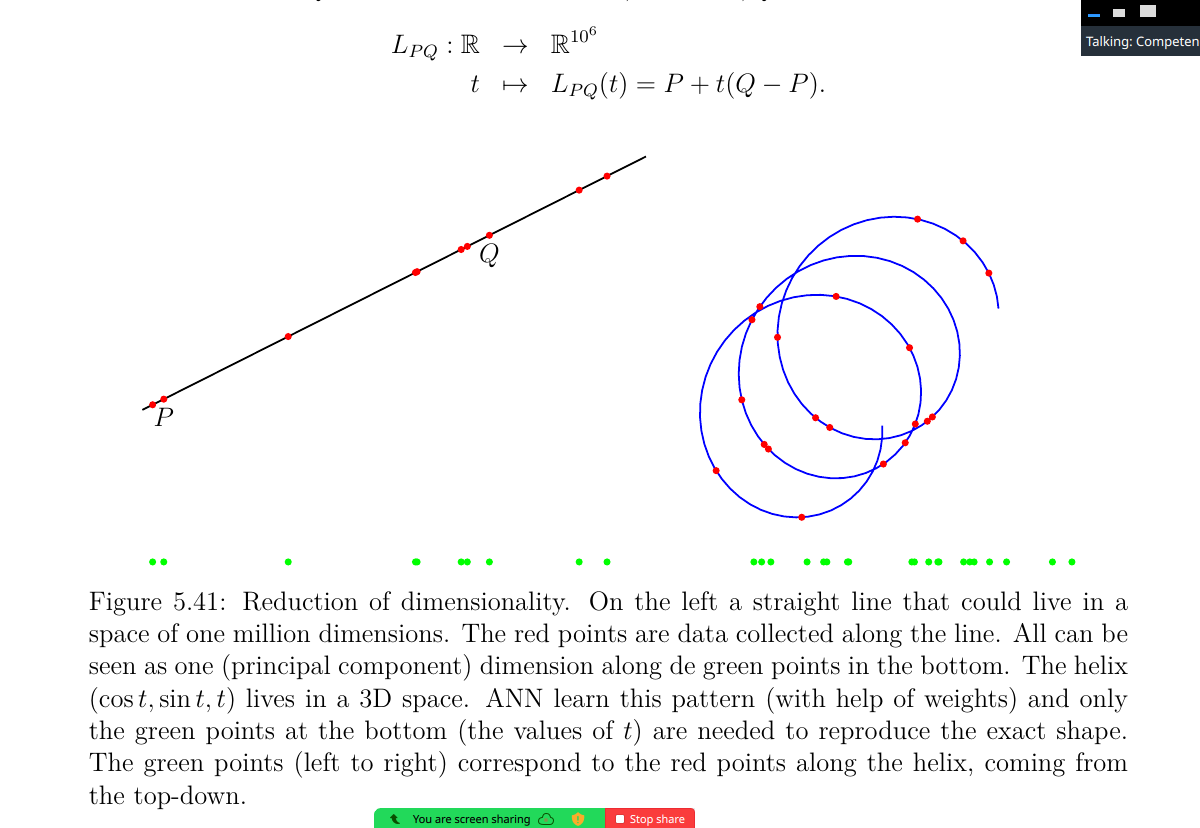

Los puntos rojos en la Figura 5.41 son los **datos**. Se puede reducir a una dimension (cada curva) y los puntos se muestran como puntos verdes en la parte inferior de las curvas. Una dimensión es la dimensión intrínseca de los datos. Si fueran superficies, entonces sería 2 las dimensiones.
Es decir que si tiene una nube de puntos, regados según la función $z=x² + y²$ (paraboloide) en 3D, los puntos se pueden determinar exactamente con una variedad en 2D (2 es la dimensión intrínseca).

Pregunta: Que pasa si tengo una nube de puntos aleatoria. No hay patrón. No hay forma de reducir la dimensión. Si la nube de puntos está en el espacio 3-dimensional, la dimensión intrínseca es 3.

El ejemplo que mostramos en `Python` usa la base de datos del MNIST. Mostramos como reducir de $28 \times 28 = 784$ dimensiones a solo 32 y verificar que la compresión es buena.

In [2]:
# dimensionality reduction on the MNST using autoencoders
# load libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Reshape

# load and preprocess MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# scale to 255
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape to 4 rank tensor
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# define dimensions
input_shape = (28, 28, 1)
encoding_dim = 32

# define the autoencoder model
input_img = Input(shape=input_shape)
x = Flatten()(input_img)
encoded = Dense(encoding_dim, activation='relu')(x)

# define the decoder
decoded = Dense(np.prod(input_shape), activation='sigmoid')(encoded)
decoded = Reshape(input_shape)(decoded)

# construct the autoencoder
autoencoder = Model(input_img, decoded)

# construct the encoder model
encoder = Model(input_img, encoded)


# compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# train the model
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.3863 - val_loss: 0.1924
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1819 - val_loss: 0.1562
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1515 - val_loss: 0.1356
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1338 - val_loss: 0.1228
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1211 - val_loss: 0.1129
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1124 - val_loss: 0.1063
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1063 - val_loss: 0.1018
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1023 - val_loss: 0.0988
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0991 - val_loss: 0.0966
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0973 - val_loss: 0.0952
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0964 - val_loss: 0.0943
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


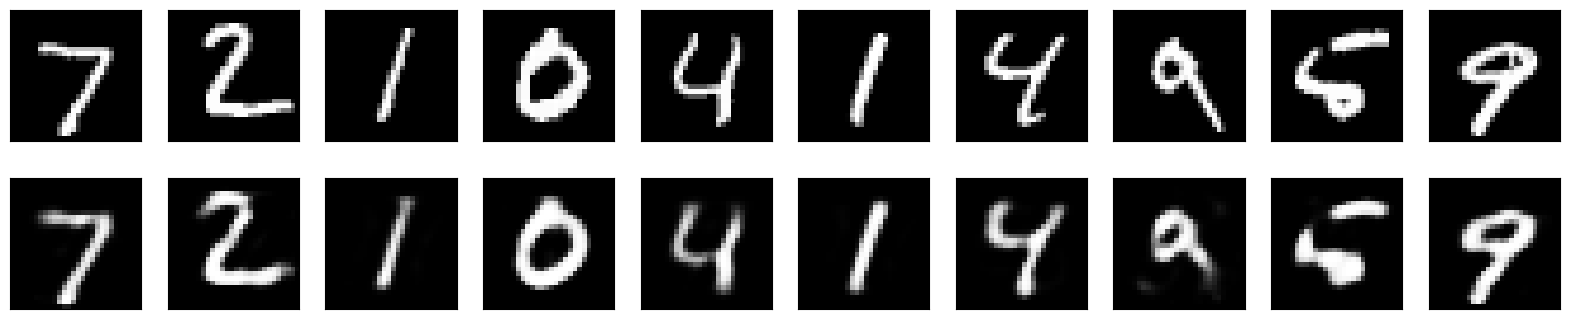

In [4]:
# vamos a probar visualmente como se comporta el algoritmo
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# probamos con 10 imágenes
n=10 # número de imagenes para probar
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1) # dos filas y 10 columnas
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display the reconstruct
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
# imprimimos las diez primeras imágenes en el espacio latente (32 dimensiones)
print("encoded representation of the first 10 test images")
print(encoded_imgs[:10])

encoded representation of the first 10 test images
[[1.36796045e+01 5.22438335e+00 3.41370153e+00 6.24504566e+00
  1.55488849e+00 1.05329037e+01 5.30157328e+00 6.74865484e+00
  3.84277916e+00 4.60156822e+00 1.08679657e+01 4.15073061e+00
  5.55903625e+00 3.61848783e+00 5.18257236e+00 8.04784870e+00
  1.10241203e+01 3.75813437e+00 4.45820951e+00 7.22289753e+00
  4.23912907e+00 8.89696312e+00 1.50980968e+01 7.45233536e+00
  7.59649277e-03 6.32764435e+00 6.62149048e+00 1.70494938e+00
  4.73123312e+00 8.25128841e+00 5.10912991e+00 5.89606857e+00]
 [5.27613735e+00 6.85232639e+00 7.25032568e-01 5.15586567e+00
  4.17155123e+00 1.18404217e+01 6.85161877e+00 8.52071095e+00
  5.53424883e+00 4.77153063e+00 5.07839918e-01 2.41634846e+00
  1.09513025e+01 1.22950134e+01 7.06099844e+00 8.02874565e+00
  7.41626930e+00 6.69808865e+00 1.95253277e+01 6.94228077e+00
  7.77955818e+00 8.05096054e+00 9.11378384e-01 5.93030643e+00
  1.12697582e+01 1.24675694e+01 1.20086279e+01 1.90921783e+01
  1.34069576e+01 8

# Comparación con PCA


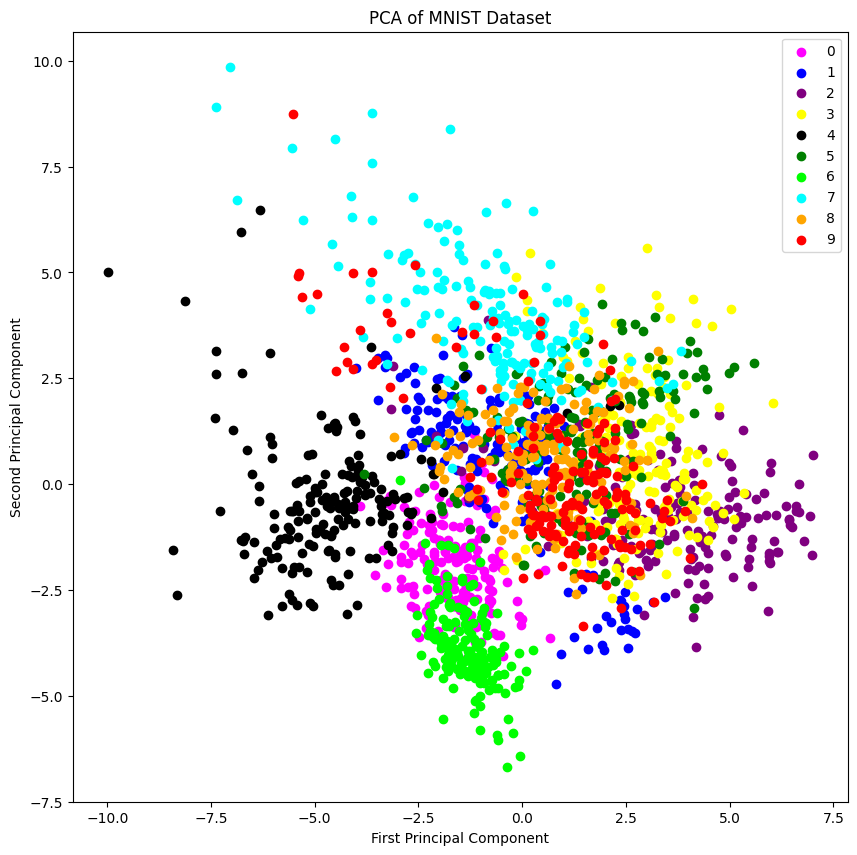

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# load the MNIST dataset
digits = datasets.load_digits()
data =  digits.data
target = digits.target

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply PCA
pca = PCA(n_components=2) # para graficarlo
data_pca = pca.fit_transform(data_scaled)

# Plot the results
plt.figure(figsize=(10, 10))

colors=['magenta', 'blue', 'purple', 'yellow', 'black', 'green', 'lime', 'cyan', 'orange', 'red']

for i in range(len(colors)):
    px = data_pca[:, 0][digits.target == i]
    py = data_pca[:, 1][digits.target == i]
    plt.scatter(px, py, c=colors[i], label=digits.target_names[i])

plt.legend()

# labels
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of MNIST Dataset')
plt.show()


## Redeucción  de dimensionalidad del MNIST con autoencoders, a 2 dimensiones.

In [14]:
from json import decoder
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape

# semilla para reproducibilidad
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# load MNIST and process
(x_train, _), (x_test, _) = mnist.load_data()
# scaled by 255
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))



# network parameters
input_shape= (784,)
encoding_dim = 2
intermedate_dim=256
batch_size=256
epochs=50

# encoder model
input_img = Input(shape=(28, 28, 1))
flat_img = Flatten()(input_img)
h = Dense(intermedate_dim, activation='relu')(flat_img)
encoded = Dense(encoding_dim, activation='relu')(h)

# decoder model
decoder_h = Dense(intermedate_dim, activation='relu')
decoder_mean = Dense(np.prod((28, 28, 1)), activation='sigmoid')
h_decoded = decoder_h(encoded)
decoded = decoder_mean(h_decoded)
reshape_output = Reshape((28, 28, 1))(decoded)


# autoencoder model
autoencoder = Model(input_img, reshape_output)
encoder = Model(input_img, encoded)

# compile model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [15]:
# train model
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.3611 - val_loss: 0.2363
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.2335 - val_loss: 0.2229
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.2221 - val_loss: 0.2157
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.2150 - val_loss: 0.2113
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.2107 - val_loss: 0.2088
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.2083 - val_loss: 0.2072
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.2067 - val_loss: 0.2059
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.2052 - val_loss: 0.2046
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.2039 - val_loss: 0.2034
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.2027 - val_loss: 0.2023
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.2015 - val_loss: 0.2012
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


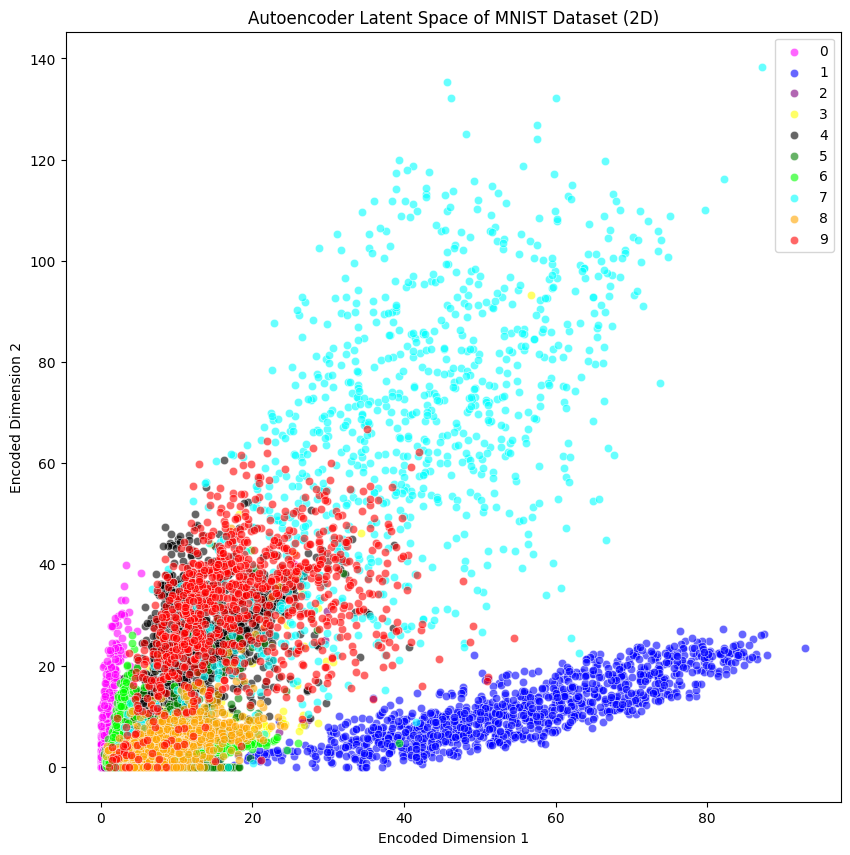

In [17]:
# graph the results
x_test_encoded = encoder.predict(x_test)
n=10

# creae a scatter plot of the encoded data
plt.figure(figsize=(10, 10))
colors=['magenta', 'blue', 'purple', 'yellow', 'black', 'green', 'lime', 'cyan', 'orange', 'red']
# use y_test labels which correspond to x_test
(x_train, y_train), (x_test, y_test) = mnist.load_data() # reload MNIST data to get y_test

for i in range(n):
    plt.scatter(x_test_encoded[:, 0][y_test == i], x_test_encoded[:, 1][y_test == i],
                c=colors[i], label=i, edgecolors='w', alpha=0.6, linewidth=0.5)
plt.legend()

# labels
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.title('Autoencoder Latent Space of MNIST Dataset (2D)')
plt.show()